In [2]:
library(tidyverse)
library(brms)
library(ape)
library(loo)
library(igraph)
library(coda)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Rcpp

Loading 'brms' package (version 2.14.4). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


This is loo version 2.5.1

- Online d

In [3]:
d <- read_csv("../data/data_cues.txt")


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Glottocode = col_character(),
  Language = col_character(),
  Genus = col_character(),
  Case_Marking = col_double(),
  Tight_Semantics = col_double(),
  Rigid_Order = col_double(),
  Verb_Middle = col_double()
)



In [4]:
head(d)

Glottocode,Language,Genus,Case_Marking,Tight_Semantics,Rigid_Order,Verb_Middle
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stan1318,Arabic,Semitic,0.036,0.218,0.655,0.391
bulg1262,Bulgarian,Slavic,0.028,0.144,0.782,0.966
croa1245,Croatian,Slavic,0.415,0.147,0.414,0.900
czec1258,Czech,Slavic,0.525,0.172,0.240,0.818
dani1285,Danish,Germanic,0.000,0.208,0.926,0.912
dutc1256,Dutch,Germanic,0.000,0.214,0.817,0.462


In [5]:
d %>%
    mutate(
        x1 = scale(Case_Marking), 
        x2 = scale(Tight_Semantics),
        x3 = scale(Rigid_Order),
        x4 = scale(Verb_Middle)
    ) -> d
head(d)

Glottocode,Language,Genus,Case_Marking,Tight_Semantics,Rigid_Order,Verb_Middle,x1,x2,x3,x4
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
stan1318,Arabic,Semitic,0.036,0.218,0.655,0.391,-0.7628649,0.826553846,0.09797316,-0.7625740
bulg1262,Bulgarian,Slavic,0.028,0.144,0.782,0.966,-0.7927616,-0.515764763,0.55542136,0.7687882
croa1245,Croatian,Slavic,0.415,0.147,0.414,0.900,0.6534927,-0.461346441,-0.77009783,0.5930144
czec1258,Czech,Slavic,0.525,0.172,0.240,0.818,1.0645728,-0.007860424,-1.39683789,0.3746289
dani1285,Danish,Germanic,0.000,0.208,0.926,0.912,-0.8974002,0.645159439,1.07410278,0.6249733
dutc1256,Dutch,Germanic,0.000,0.214,0.817,0.462,-0.8974002,0.753996083,0.68148976,-0.5734840


In [6]:
phylo <- read.nexus("../data/mcc.tre")

In [7]:
A <- 10*ape::vcv.phylo(phylo)

### Running the PC algorithm by hand

In [9]:
checkIndependence <- function(iv, dv) {
    frm <- as.formula(
        str_c(c(dv, " ~ ", str_c(iv, collapse=" + "), " + (1|gr(Language, cov = A))"), collapse="")
    )
    frm0 <- as.formula(str_c(c(dv, " ~ ", str_c(iv, collapse=" + ")), collapse=""))
    model <- brm(
        frm,
        data=d,
        data2 = list(A = A),
        prior = c(
            prior(normal(0, 1), "b"),
            prior(normal(0, 1), "Intercept"),
            prior(student_t(3, 0, 20), "sd"),
            prior(student_t(3, 0, 20), "sigma")
        ),
        iter=10000,
        refresh=0,
        control=list(adapt_delta=0.999),
    )
    model <- add_criterion(model, "loo")

    null_model <- brm(
        frm0,
        data=d,
        data2 = list(A = A),
        prior = c(
            prior(normal(0, 1), "b"),
            prior(normal(0, 1), "Intercept"),
            prior(student_t(3, 0, 20), "sigma")
        ),
        iter=10000,
        refresh=0,
        control=list(adapt_delta=0.999),
    )
    null_model <- add_criterion(null_model, "loo")


    mc <- loo_compare(model, null_model)

    if (as.numeric(which.min(mc[,"looic"])) == 1) {
        winner <- model
    } else {
        winner <- null_model
    }
    return(summary(winner, prob=0.5))
}

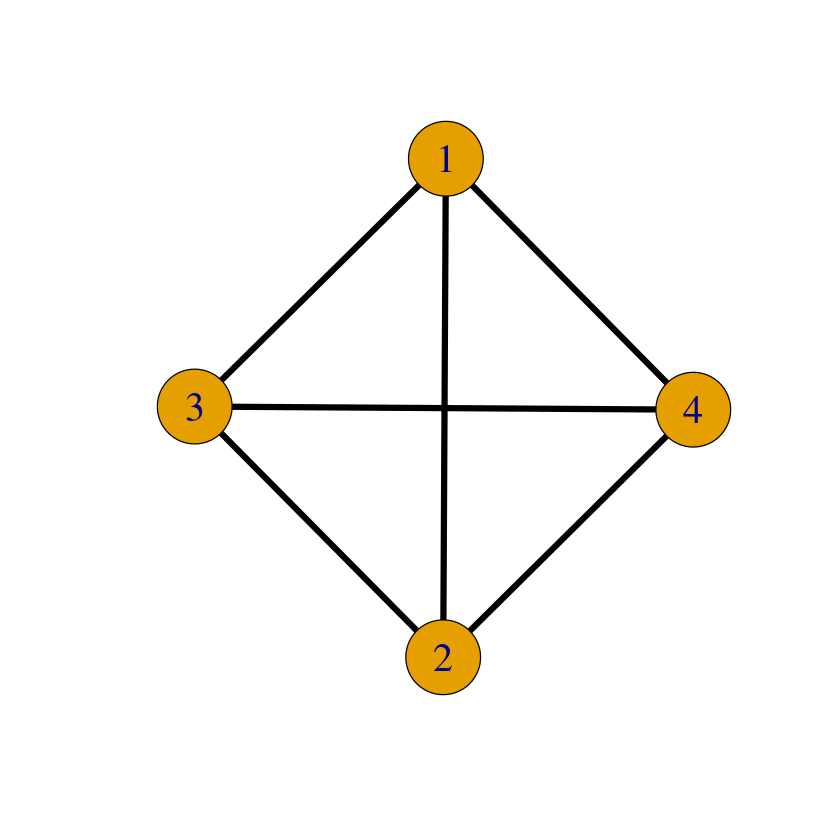

In [40]:
g <- make_full_graph(4)
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [11]:
dv <- "x1"
iv <- c("x2")

In [12]:
md <- checkIndependence(iv, dv)

Compiling Stan program...

Start sampling

Warning message:
“There were 17 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 5 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning message:
“Found 18 observations with a pareto_k > 0.7 in model 'model'. I

In [13]:
md

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x1 ~ x2 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.51      0.13     0.42     0.59 1.00      965     3189

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.06      0.32    -0.15     0.27 1.00     4590     5755
x2            0.22      0.16     0.11     0.33 1.00     6823     9531

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.44      0.20     0.29     0.57 1.01      489      333

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is th

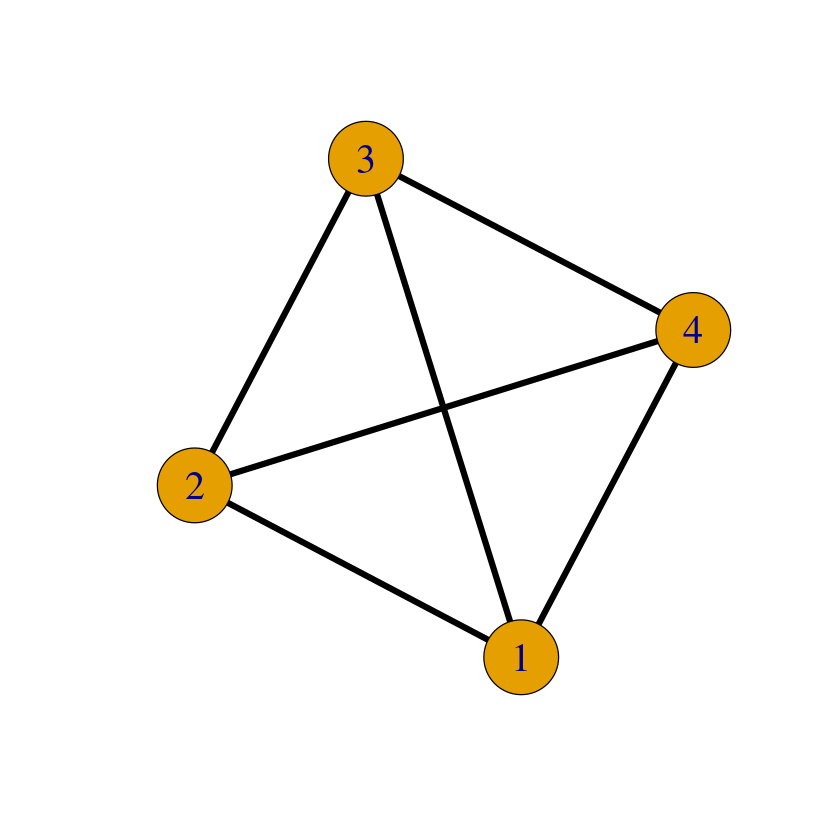

In [14]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [15]:
dv <- "x1"
iv <- c("x3")

In [16]:
md <- checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 136 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 8516 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.08, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means an

In [17]:
md

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x1 ~ x3 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.41      0.07     0.37     0.46 1.07       37      453

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.03      0.22    -0.10     0.16 1.08      564     1071
x3           -0.76      0.13    -0.83    -0.67 1.06      297     1701

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.17      0.13     0.08     0.24 1.06       50       20

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is th

In [18]:
dv <- "x1"
iv <- c("x4")

In [19]:
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 269 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning mess

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x1 ~ x4 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.54      0.11     0.46     0.61 1.00     1032     3996

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.08      0.35    -0.30     0.15 1.00     4265     5022
x4           -0.35      0.21    -0.48    -0.21 1.00     3025     1928

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.35      0.19     0.20     0.47 1.01      376      283

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is th

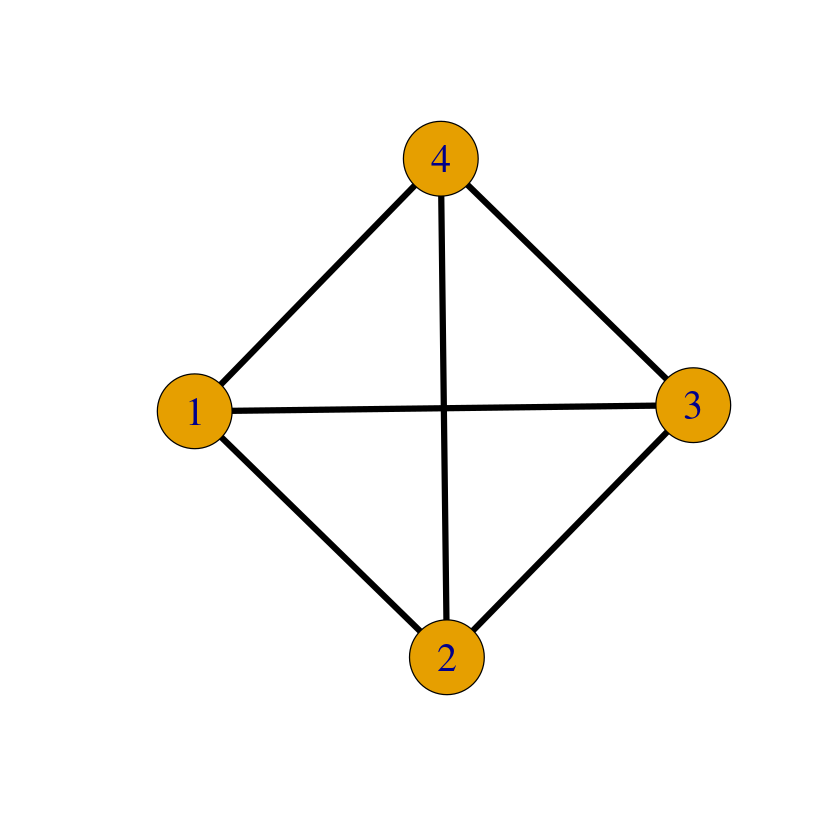

In [20]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [21]:
dv <- "x2"
iv <- c("x3")
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 16 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 2986 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (E

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x2 ~ x3 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.54      0.24     0.38     0.71 1.00      449     2576

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.05      0.37    -0.19     0.27 1.00     4798     4065
x3           -0.16      0.23    -0.31    -0.01 1.00     6456     7858

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.58      0.33     0.31     0.84 1.01      312      375

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is th

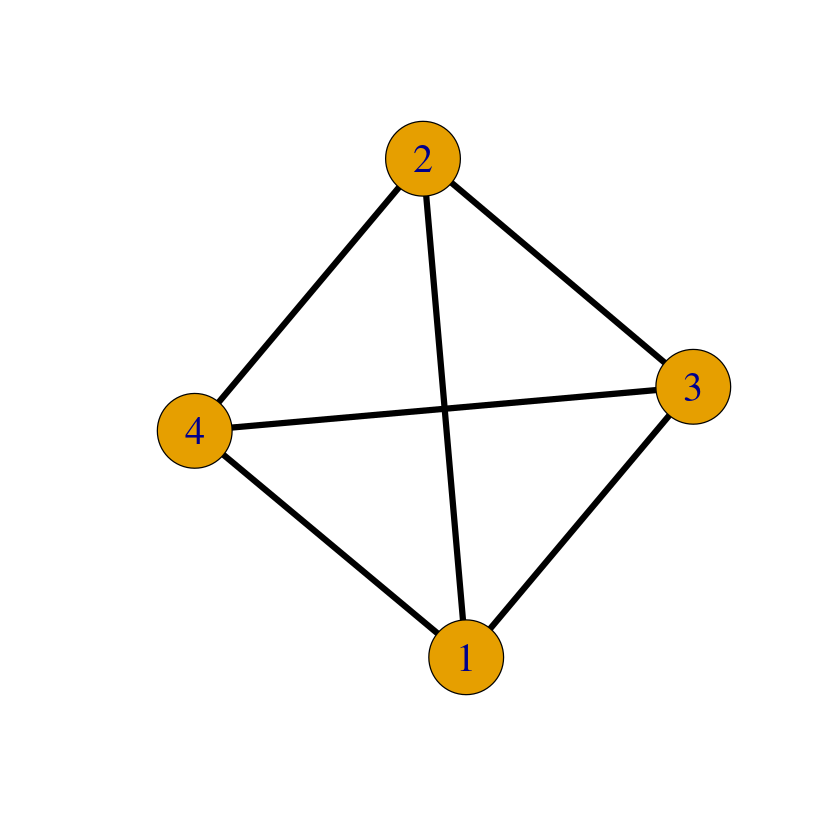

In [22]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [23]:
dv <- "x2"
iv <- c("x4")
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 3922 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3685 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.8, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means an

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x2 ~ x4 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.61      0.20     0.52     0.75 1.17       16       67

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.27      0.39    -0.59    -0.02 1.28       11       39
x4           -0.40      0.21    -0.57    -0.20 1.23       12      162

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.33      0.35     0.05     0.61 1.79        6       16

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is th

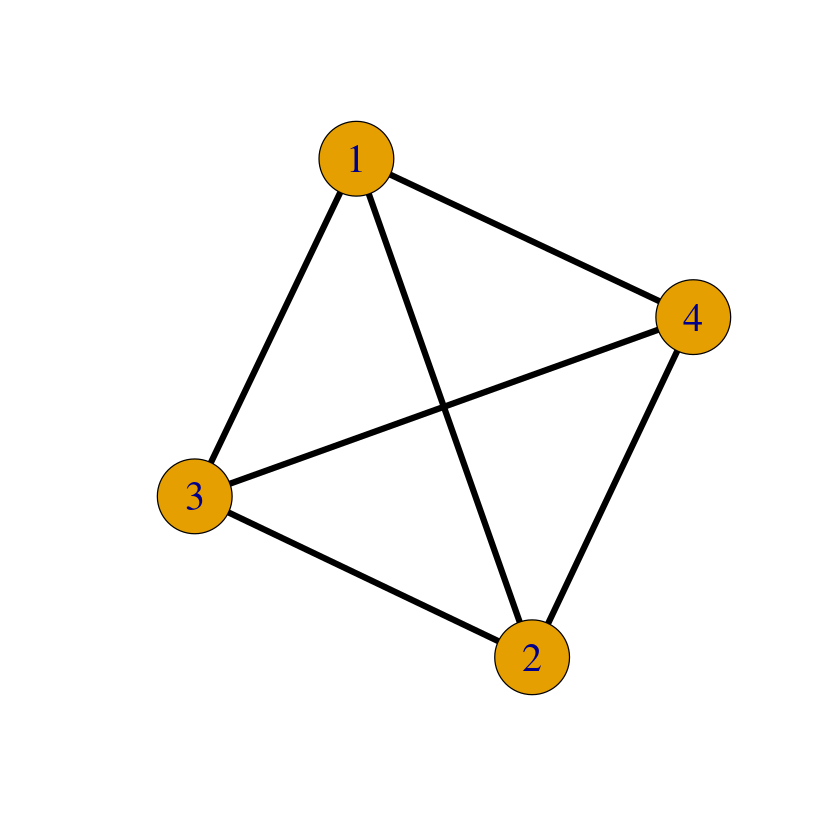

In [24]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [25]:
dv <- "x3"
iv <- c("x4")
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 48 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 1282 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (E

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x3 ~ x4 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.55      0.10     0.48     0.61 1.00     1298     4331

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.10      0.35    -0.13     0.33 1.00     4123     6215
x4            0.33      0.21     0.19     0.46 1.00     3795     5501

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.29      0.18     0.15     0.41 1.01      316      254

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is th

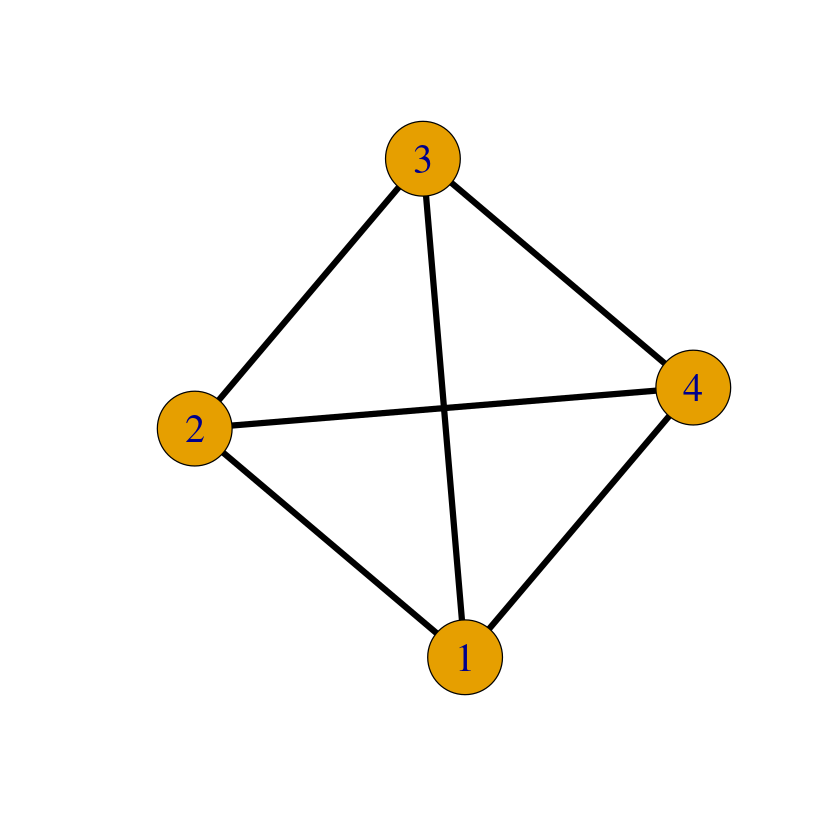

In [26]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [27]:
dv <- "x1"
iv <- c("x2", "x4")
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 238 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 6145 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x1 ~ x2 + x4 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.53      0.12     0.45     0.61 1.01      434      308

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.07      0.35    -0.30     0.16 1.00     1499     3038
x2            0.15      0.18     0.03     0.26 1.00     2226     3502
x4           -0.28      0.23    -0.43    -0.12 1.00     1444     3495

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.37      0.20     0.22     0.50 1.01      275      213

Samples were drawn using sampling(NUTS). For each paramete

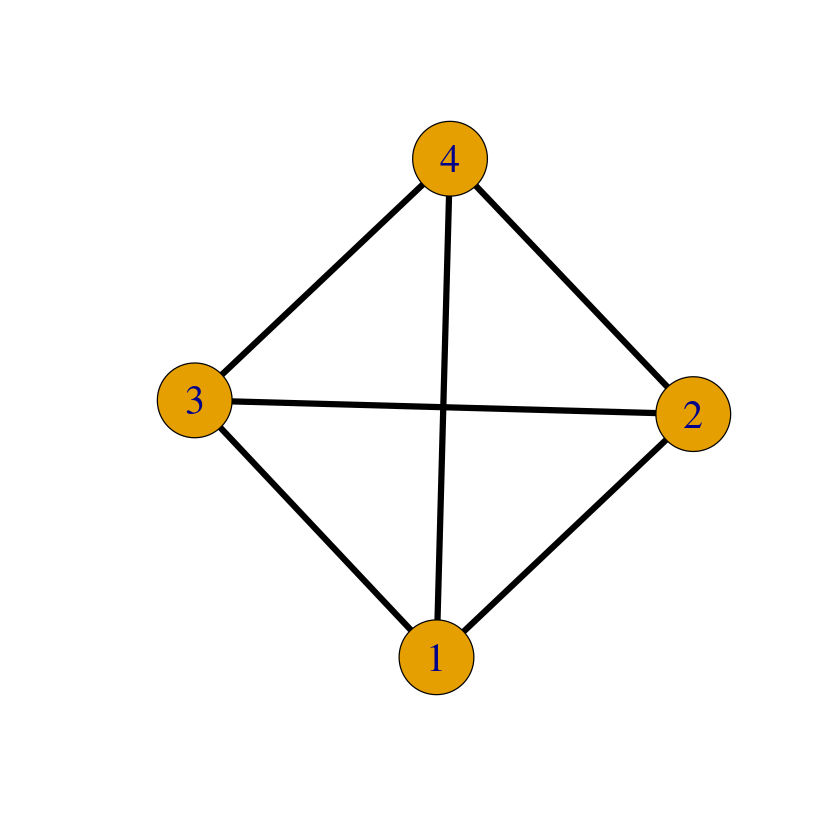

In [28]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [29]:
dv <- "x1"
iv <- c("x2", "x3")
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 473 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 171 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (E

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x1 ~ x2 + x3 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.39      0.09     0.34     0.44 1.01      976     2035

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.03      0.24    -0.13     0.18 1.00     5028     6837
x2            0.13      0.12     0.06     0.21 1.00     5473     7513
x3           -0.74      0.14    -0.83    -0.65 1.00     3647     7631

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.22      0.15     0.10     0.30 1.01      258      160

Samples were drawn using sampling(NUTS). For each paramete

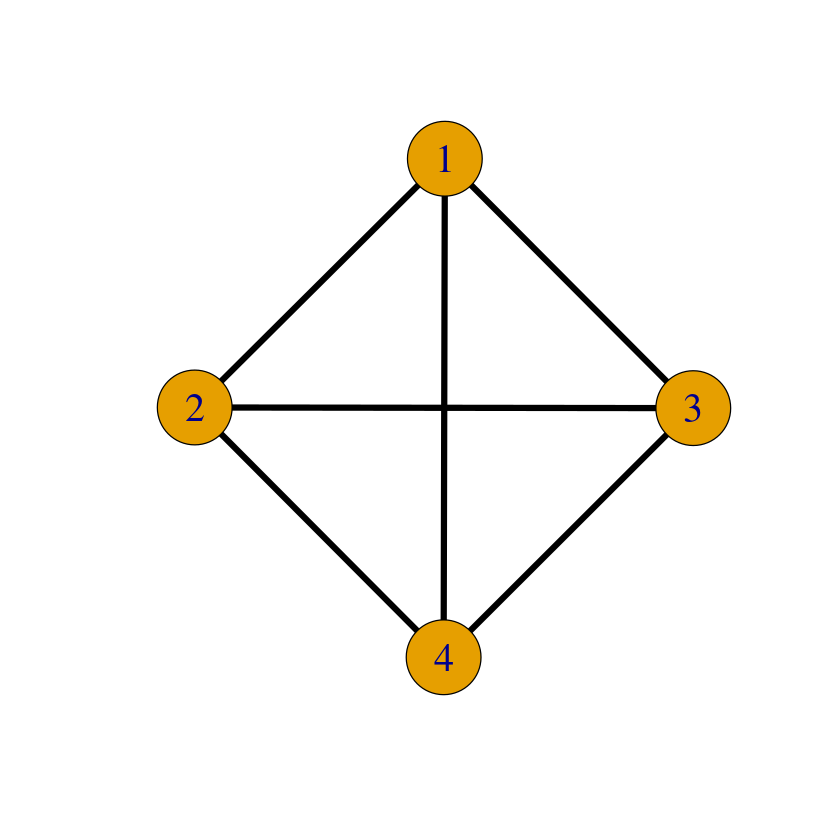

In [30]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [31]:
dv <- "x2"
iv <- c("x3", "x4")
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 259 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning mess

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x2 ~ x3 + x4 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.51      0.23     0.35     0.67 1.00      515     1363

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.09      0.36    -0.31     0.14 1.00     5816     5712
x3           -0.07      0.22    -0.22     0.07 1.00     7695     8611
x4           -0.37      0.24    -0.52    -0.22 1.00     4248     2668

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.59      0.30     0.35     0.83 1.01      344      258

Samples were drawn using sampling(NUTS). For each paramete

In [32]:
E(g)

+ 6/6 edges from bfb80e5:
[1] 1--2 1--3 1--4 2--3 2--4 3--4

In [41]:
g <- delete_edges(g, 4)

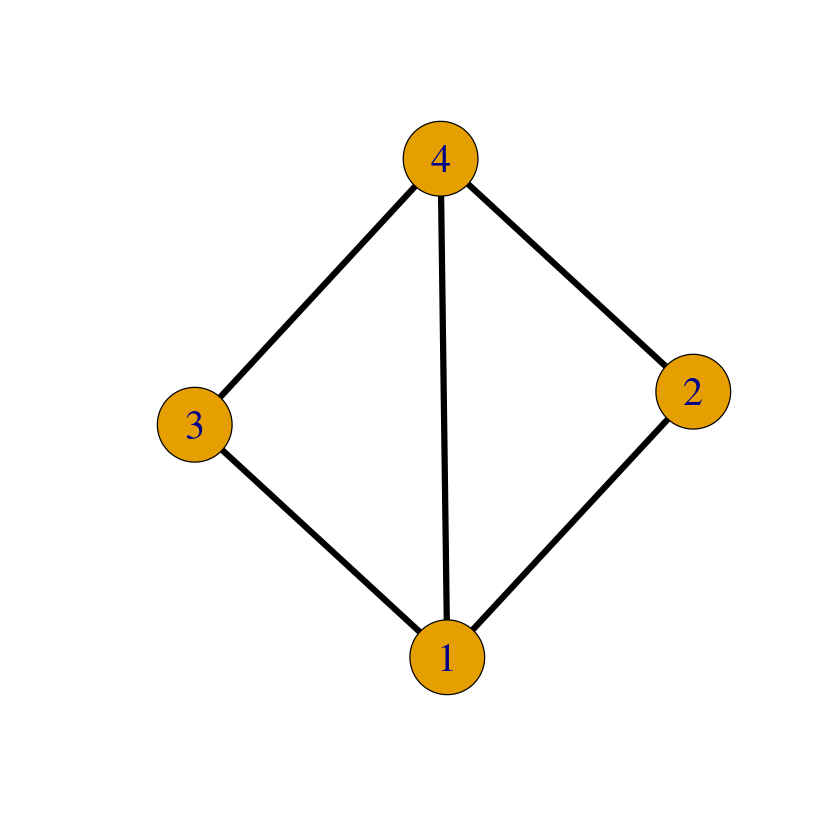

In [42]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [35]:
dv <- "x2"
iv <- c("x4", "x1")
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 537 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning mess

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x2 ~ x4 + x1 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.46      0.24     0.26     0.65 1.02      247     1660

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.08      0.34    -0.28     0.12 1.00     3855     3753
x4           -0.33      0.24    -0.48    -0.18 1.01     1058      259
x1            0.22      0.22     0.07     0.37 1.01     1926     5992

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.61      0.31     0.36     0.85 1.04      153       99

Samples were drawn using sampling(NUTS). For each paramete

In [36]:
dv <- "x3"
iv <- c("x4", "x1")
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 51 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 9303 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (E

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x3 ~ x4 + x1 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.40      0.07     0.36     0.44 1.01     1266     2007

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.03      0.26    -0.15     0.20 1.00      993     2490
x4            0.08      0.16    -0.03     0.19 1.00      967     1699
x1           -0.69      0.14    -0.78    -0.60 1.00     1406     1895

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.15      0.12     0.06     0.21 1.02      158      147

Samples were drawn using sampling(NUTS). For each paramete

In [43]:
E(g)

+ 5/5 edges from d742f01:
[1] 1--2 1--3 1--4 2--4 3--4

In [44]:
g <- delete_edges(g,5)

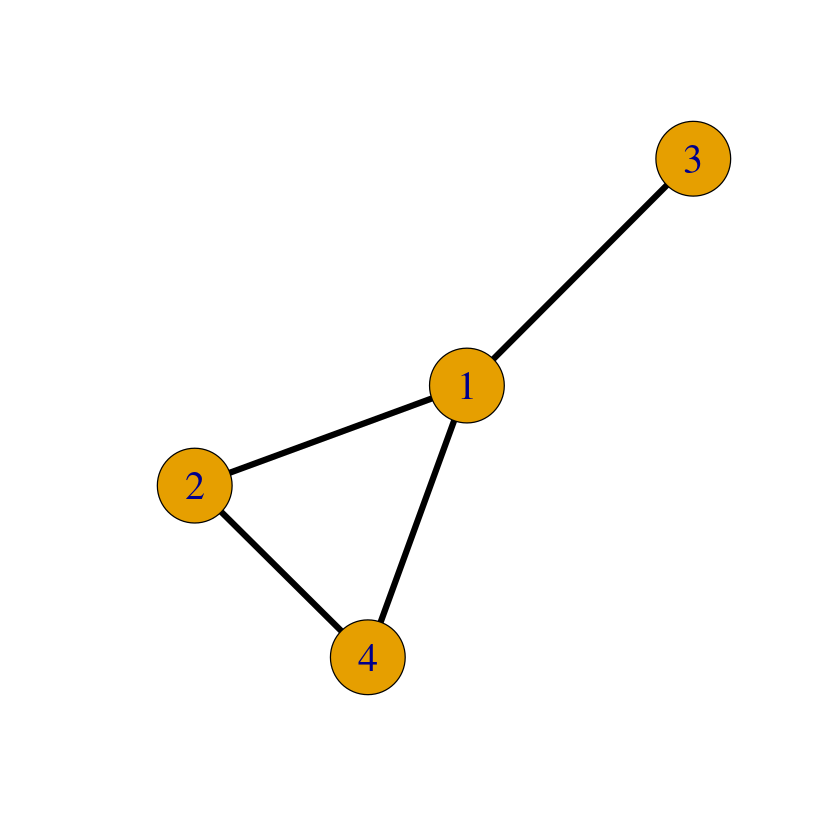

In [45]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [46]:
dv <- "x2"
iv <- c("x3", "x1")
checkIndependence(iv, dv)

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 27 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 4978 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (E

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x2 ~ x3 + x1 + (1 | gr(Language, cov = A)) 
   Data: d (Number of observations: 30) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~Language (Number of levels: 30) 
              Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.47      0.25     0.26     0.67 1.02      205      722

Population-Level Effects: 
          Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.00      0.34    -0.20     0.20 1.01     1259     1116
x3            0.11      0.31    -0.09     0.32 1.00     1786     2853
x1            0.38      0.31     0.18     0.59 1.00     1562     2538

Family Specific Parameters: 
      Estimate Est.Error l-50% CI u-50% CI Rhat Bulk_ESS Tail_ESS
sigma     0.65      0.32     0.39     0.90 1.02      186      261

Samples were drawn using sampling(NUTS). For each paramete